<a href="https://colab.research.google.com/github/mohsenshekarabi/PriceRegression/blob/main/PricePredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import torch
import torch.nn as nn
import pandas as pd
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [103]:
Dataset_Train = pd.read_csv("https://raw.githubusercontent.com/mohsenshekarabi/PriceRegression/main/train.csv")
Dataset_Test = pd.read_csv("https://raw.githubusercontent.com/mohsenshekarabi/PriceRegression/main/test.csv")

Dataset_Train.set_index("Date", inplace = True)
Dataset_Test.set_index("Date", inplace = True)



In [104]:
from copy import deepcopy as dc

LookBack = 7

def PrepareDataForLSTM(DF, Col="Close",LookBack=7):

  DF = dc(DF)

  Cols = list(Dataset_Train.columns)
  Cols.remove(Col)
  UnlessCols = Cols


  DF = DF.drop(columns=UnlessCols)


  for i in range(1, LookBack + 1):
    DF[Col+f"(t-{i})"] = DF[Col].shift(i)

  DF.dropna(inplace=True)

  return DF


ShiftedDF_Train = PrepareDataForLSTM(Dataset_Train)

ShiftedDF_Test = PrepareDataForLSTM(Dataset_Test)



In [106]:
from sklearn.preprocessing import MinMaxScaler


Scaler = MinMaxScaler(feature_range=(-1, 1))
#return Scaler.fit_transform(Data)


ShiftedDF_Train = Scaler.fit_transform(ShiftedDF_Train)
ShiftedDF_Test = Scaler.fit_transform(ShiftedDF_Test)




In [107]:
x_train = ShiftedDF_Train[:, 1:]
y_train = ShiftedDF_Train[:, 0]

x_test = ShiftedDF_Test[:, 1:]
y_test = ShiftedDF_Test[:, 0]

x_train = x_train.reshape((-1, LookBack, 1))
x_test = x_test.reshape((-1, LookBack, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

x_train.shape, y_train.shape, x_test.shape, y_test.shape



(torch.Size([1493, 7, 1]),
 torch.Size([1493, 1]),
 torch.Size([23, 7, 1]),
 torch.Size([23, 1]))

In [108]:
from torch.utils.data import Dataset

class TimeSeriesDataSet(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, i):
    return self.x[i], self.y[i]

train_dataset = TimeSeriesDataSet(x_train, y_train)
test_dataset = TimeSeriesDataSet(x_test, y_test)



In [109]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [110]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  break

In [111]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        batch_size = x.size(0)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)

model.to(device)

model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [112]:
def train_one_epoch():

    model.train(True)

    running_loss = 8.0


    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        outputs = model(x_batch)

        loss = loss_function(outputs, y_batch)
        running_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            ave_last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(batch_index + 1, ave_last_loss))

            running_loss = 0.


In [113]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
      x_batch, y_batch = batch[0].to(device), batch[1].to(device)

      with torch.no_grad():
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Batch{0}, Loss {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
  print("#################################################")

In [114]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()


Batch94, Loss 39.193
#################################################
Batch94, Loss 18.455
#################################################
Batch94, Loss 8.954
#################################################
Batch94, Loss 4.194
#################################################
Batch94, Loss 1.874
#################################################
Batch94, Loss 0.915
#################################################
Batch94, Loss 0.575
#################################################
Batch94, Loss 0.454
#################################################
Batch94, Loss 0.393
#################################################
Batch94, Loss 0.352
#################################################
Batch94, Loss 0.315
#################################################
Batch94, Loss 0.286
#################################################
Batch94, Loss 0.262
#################################################
Batch94, Loss 0.239
#################################################
Batch94, Loss 0.22

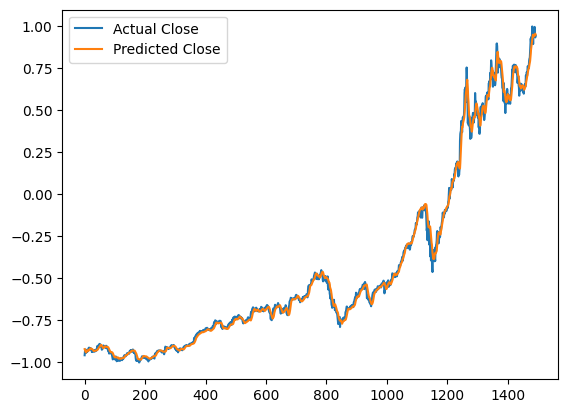

In [115]:
import matplotlib.pyplot as plt

with torch.no_grad():
  predicted = model(x_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.legend()
plt.show()


In [118]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_train, predicted, squared=False)
rmse

0.031291697